# South bay area house price analysis and investment recommendation

## Introduction: business problem

  * South bay area median house price tops United States as one of the most expensive regions
  * House price in this region still grows with double digits YOY, which makes it attractive investment activity
  * Before pouring tons of money into real estate market, the following questions needs to be answered:
    * What is the major driving force for the house price increase 
    * Which city from south bay area is most promising for investment in terms of job opportunities, next generation education and life convenience
    
## Who will be interested in this project
  * The problem mentioned above is applicable to investors who want to invest in Silicon Valley housing and real estate
  * Young engineers and scientists who just moved to Silicon Valley and are trying to make decision whether to buy their house sfrom Silicon Valley and which location to choose

## Data analysis method invovled
  * Linear regression, Foursquare data query, Folium mapping

## Data Acquisition and Cleaning
  * Nasdaq, Dow Jones and S&P 500 stock price from 1996 to 2021, downloaded from Yahoo finance. 6 features in the sheets, but only Close(stock price) and Date is used.
  * United State house price, supply and demand data from 1996 to 2021 is downloaded from Office of Policy Development and Research(PD&R)
  * Santa Clara county house supply vs demand, median house sale price from 2012-2021 is downloaded from Redfin 
  * Neighborhood data is downloaded from County of Santa Clara SCCgov website. 65536 neighborhood* 71 features are in the raw data. After cleaning, the neighborhood is grouped  based on city, and only 7 features will be used
  * Santa Clara School rating is summarized based on GreatSchools.org website and Santa Clara County SCCgov website
  * Silicon Valley companies’ coordination is downloaded from github
  
## Results and discussion
  * Based on job selection opportunities and public school rating, Palo Alto, west Mountainview, west Sunnyvale and north Cupertino are best choice. 
  * Job opportunities:
    * Mountainview, Sunnyvale, Palo Alto and Santa Clara have more selection of companies 
  * Public school system:
    * Cupertino, Palo Alto, west Mountainview, west Sunnyvale, Saratoga, and Los Gatos have more public schools with rating >=8
  * Asian food
    * San Jose area has relatively more Asian food restaurants (based on those having coordination from Foursquare)
    
## Conclusions
  * Stock price is the major driving force for south bay area house price growth
  * House supply is not the major factor for rapid house price growth, especially for single family house
  * Education level and median house income, location convenience have positive impact on house price
  * More data from individual house informaton will be helpful for further deep dive into the analysis

In [418]:
# Install geopy for plotting
!pip install geopy
!conda install -c conda-forge folium=0.5.0 --yes

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
Defaulting to user installation because normal site-packages is not writeable
Solving environment: done

# All requested packages already installed.



In [433]:
#Import database
import pandas as pd
import requests
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import json
from geopy.geocoders import nominatim
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
import folium
import lxml.html
from pandas import DataFrame
print('libarary imported')

libarary imported


In [434]:
# Read Stock historical data into dataframe
Nasdaq=pd.read_csv("/Users/dwang/Downloads/IXIC.csv",skiprows=1,header=None, usecols=[0,4])
Dow=pd.read_csv("/Users/dwang/Downloads/DJI.csv",skiprows=1,header=None, usecols=[0,4])
SP=pd.read_csv("/Users/dwang/Downloads/GSPC.csv",skiprows=1,header=None, usecols=[0,4])
House_price=pd.read_excel("/Users/dwang/Downloads/House price.xls",skiprows=2,header=None, usecols=[0,1,2])
House_price.head()

,0,1,2
0,1996-01-01,106700,247216
1,1996-02-01,106727,246571
2,1996-03-01,106777,246344
3,1996-04-01,106902,245980
4,1996-05-01,107044,246043


In [435]:
# Data cleaning, change column names
Nasdaq=Nasdaq.rename(columns={0:"Date",4:"Nasdaq"})
Dow=Dow.rename(columns={0:"Date",4:"Dow"})
SP=SP.rename(columns={0:"Date",4:"S&P 500"})
House_price=House_price.rename(columns={0:"Date",1:"United", 2: "San Jose area"})

In [436]:
# select years for 3 stock index data since 1999 so econimc crisis in 2000 can be included for analysis
Nasdaq['Date'] = pd.to_datetime(Nasdaq['Date']) 
Dow['Date'] = pd.to_datetime(Dow['Date']) 
SP['Date'] = pd.to_datetime(SP['Date'])
Nasdaq=Nasdaq.loc[(Nasdaq['Date'] >= '1999-1-1')].reset_index(drop=True)
Dow=Dow.loc[(Dow['Date'] >= '1999-1-1')].reset_index(drop=True)
SP=SP.loc[(SP['Date'] >= '1999-1-1')].reset_index(drop=True)
House_price=House_price.loc[(House_price['Date'] >= '1999-1-1')].reset_index(drop=True)
House_price

,Date,United,San Jose area
0,1999-01-01,118105,322846
1,1999-02-01,118580,326279
2,1999-03-01,119106,329608
3,1999-04-01,119727,331202
4,1999-05-01,120322,333132
...,...,...,...
259,2020-08-01,255671,1212659
260,2020-09-01,257971,1230406
261,2020-10-01,260504,1251580
262,2020-11-01,263250,1268214


In [437]:
# combine stock price and house price data into one dataframe
Dow=Dow['Dow']
SP=SP['S&P 500']
House_price=House_price.drop(['Date'],axis=1)
Stock=pd.concat([Nasdaq,Dow,SP,House_price],axis=1)
Stock

,Date,Nasdaq,Dow,S&P 500,United,San Jose area
0,1999-01-01,2505.889893,9358.830078,1279.640015,118105.0,322846.0
1,1999-02-01,2288.030029,9306.580078,1238.329956,118580.0,326279.0
2,1999-03-01,2461.399902,9786.160156,1286.369995,119106.0,329608.0
3,1999-04-01,2542.860107,10789.040039,1335.180054,119727.0,331202.0
4,1999-05-01,2470.520020,10559.740234,1301.839966,120322.0,333132.0
...,...,...,...,...,...,...
262,2020-11-01,12198.740234,29638.640625,3621.629883,263250.0,1268214.0
263,2020-12-01,12888.280273,30606.480469,3756.070068,266104.0,1287714.0
264,2021-01-01,13070.690430,29982.619141,3714.239990,NaN,NaN
265,2021-02-01,14095.469727,31458.400391,3934.830078,NaN,NaN


In [438]:
# calculate stock price and house price growth rate based on year 1999 data
Stock['Nasdaq %']=(Stock['Nasdaq']-Stock['Nasdaq'][0])/Stock['Nasdaq'][0]*100
Stock['Dow %']=(Stock['Dow']-Stock['Dow'][0])/Stock['Dow'][0]*100
Stock['S&P 500 %']=(Stock['S&P 500']-Stock['S&P 500'][0])/Stock['S&P 500'][0]*100
Stock['United %']=(Stock['United']-Stock['United'][0])/Stock['United'][0]*100
Stock['San Jose area %']=(Stock['San Jose area']-Stock['San Jose area'][0])/Stock['San Jose area'][0]*100
Stock

,Date,Nasdaq,Dow,S&P 500,United,San Jose area,Nasdaq %,Dow %,S&P 500 %,United %,San Jose area %
0,1999-01-01,2505.889893,9358.830078,1279.640015,118105.0,322846.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,1999-02-01,2288.030029,9306.580078,1238.329956,118580.0,326279.0,-8.693912,-0.558296,-3.228256,0.402184,1.063355
2,1999-03-01,2461.399902,9786.160156,1286.369995,119106.0,329608.0,-1.775417,4.566063,0.525928,0.847551,2.094497
3,1999-04-01,2542.860107,10789.040039,1335.180054,119727.0,331202.0,1.475333,15.281931,4.340286,1.373354,2.588231
4,1999-05-01,2470.520020,10559.740234,1301.839966,120322.0,333132.0,-1.411470,12.831841,1.734859,1.877143,3.186039
...,...,...,...,...,...,...,...,...,...,...,...
262,2020-11-01,12198.740234,29638.640625,3621.629883,263250.0,1268214.0,386.802723,216.691727,183.019431,122.894882,292.823204
263,2020-12-01,12888.280273,30606.480469,3756.070068,266104.0,1287714.0,414.319496,227.033189,193.525525,125.311375,298.863235
264,2021-01-01,13070.690430,29982.619141,3714.239990,NaN,NaN,421.598753,220.367171,190.256630,NaN,NaN
265,2021-02-01,14095.469727,31458.400391,3934.830078,NaN,NaN,462.493578,236.136035,207.495079,NaN,NaN


In [439]:
# Remove raw data columns, only keep growth rate columns
Stock=Stock.drop(['Nasdaq','Dow','S&P 500','United','San Jose area'],axis=1)
Stock.set_index('Date')

,Nasdaq %,Dow %,S&P 500 %,United %,San Jose area %
Date,,,,,
1999-01-01,0.000000,0.000000,0.000000,0.000000,0.000000
1999-02-01,-8.693912,-0.558296,-3.228256,0.402184,1.063355
1999-03-01,-1.775417,4.566063,0.525928,0.847551,2.094497
1999-04-01,1.475333,15.281931,4.340286,1.373354,2.588231
1999-05-01,-1.411470,12.831841,1.734859,1.877143,3.186039
...,...,...,...,...,...
2020-11-01,386.802723,216.691727,183.019431,122.894882,292.823204
2020-12-01,414.319496,227.033189,193.525525,125.311375,298.863235
2021-01-01,421.598753,220.367171,190.256630,NaN,NaN


In [440]:
Stock=Stock[Stock['United %'].notna()]
Stock

,Date,Nasdaq %,Dow %,S&P 500 %,United %,San Jose area %
0,1999-01-01,0.000000,0.000000,0.000000,0.000000,0.000000
1,1999-02-01,-8.693912,-0.558296,-3.228256,0.402184,1.063355
2,1999-03-01,-1.775417,4.566063,0.525928,0.847551,2.094497
3,1999-04-01,1.475333,15.281931,4.340286,1.373354,2.588231
4,1999-05-01,-1.411470,12.831841,1.734859,1.877143,3.186039
...,...,...,...,...,...,...
259,2020-08-01,369.911308,203.777828,173.538653,116.477711,275.615309
260,2020-09-01,345.650457,196.850130,162.808287,118.425130,281.112357
261,2020-10-01,335.437721,183.172142,155.537489,120.569832,287.670902
262,2020-11-01,386.802723,216.691727,183.019431,122.894882,292.823204


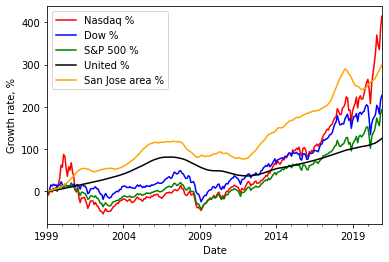

In [441]:
# Overlaid line plot to compare the growth trend
ax = plt.gca()
plt.ylabel('Growth rate, %')

Stock.plot(kind='line',x='Date',y='Nasdaq %',color='red',ax=ax)
Stock.plot(kind='line',x='Date',y='Dow %',color='blue',ax=ax)
Stock.plot(kind='line',x='Date',y='S&P 500 %',color='green',ax=ax)
Stock.plot(kind='line',x='Date',y='United %',color='black',ax=ax)
Stock.plot(kind='line',x='Date',y='San Jose area %',color='orange',ax=ax)

plt.show()

In [442]:
# Use linear regression model and train-test dataset to verify stock market vs house price correlation variance
msk = np.random.rand(len(Stock)) < 0.8
train = Stock[msk]
test = Stock[~msk]


from sklearn import linear_model
regr = linear_model.LinearRegression()
x = np.asanyarray(train[['Nasdaq %','Dow %','S&P 500 %']])
y = np.asanyarray(train[['San Jose area %']])
regr.fit (x, y)
# The coefficients
print ('Coefficients: ', regr.coef_)

y_hat= regr.predict(test[['Nasdaq %','Dow %','S&P 500 %']])
x = np.asanyarray(test[['Nasdaq %','Dow %','S&P 500 %']])
y = np.asanyarray(test[['San Jose area %']])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x, y))

Coefficients:  [[-0.13000817  2.1118417  -0.91536778]]
Residual sum of squares: 622.15
Variance score: 0.92


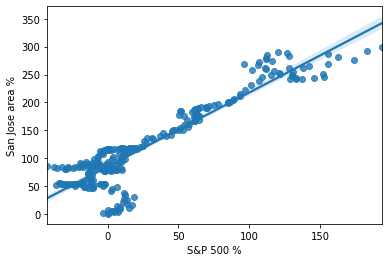

In [443]:
sns.regplot(x='S&P 500 %',y='San Jose area %', data=Stock)

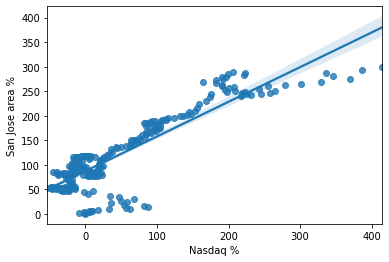

In [444]:
sns.regplot(x='Nasdaq %',y='San Jose area %', data=Stock)

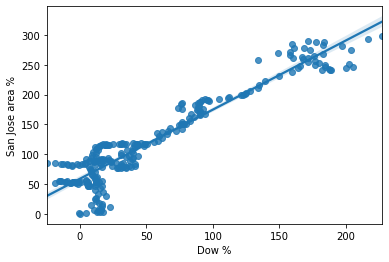

In [445]:
sns.regplot(x='Dow %',y='San Jose area %', data=Stock)

In [446]:
# Read Santa Clara County house sale,inventory and median price data
SC_price=pd.read_excel("/Users/dwang/Downloads/Santa Clara median sale.xlsx",skiprows=0,header=None, usecols="B:DD")
Inv=pd.read_excel("/Users/dwang/Downloads/Santa Clara inventory.xlsx",skiprows=0,header=None, usecols="B:DD")
Sale=pd.read_excel("/Users/dwang/Downloads/Santa Clara sales.xlsx",skiprows=0,header=None, usecols="B:DD")
Sale.head()

,1,2,3,4,5,6,7,8,9,10,...,98,99,100,101,102,103,104,105,106,107
0,February 2012,March 2012,April 2012,May 2012,June 2012,July 2012,August 2012,September 2012,October 2012,November 2012,...,March 2020,April 2020,May 2020,June 2020,July 2020,August 2020,September 2020,October 2020,November 2020,December 2020
1,1499.787175,1494.775356,1495.772187,1484.223894,1441.453992,1407.815422,1381.004409,1379.875151,1403.756187,1417.388358,...,967.068626,859.246511,794.939637,1159.153124,1237.026641,1238.871318,1268.159652,1287.75264,1285.188888,1237.406655


In [447]:
SC_price1=SC_price.T
Inv1=Inv.T
Sale1=Sale.T

In [448]:
# Data cleaning, and combine house data into one dataframe
SC_price1=SC_price1.rename(columns={0:"NaN",1:"Date", 2: "Price"})
Inv1=Inv1.rename(columns={0:"Date", 1: "Inventory"})
Sale1=Sale1.rename(columns={0:"Date", 1: "Sale"})
SC_price1=SC_price1[["Date","Price"]]
Inv1=Inv1[['Inventory']]
Sale1=Sale1[['Sale']]
D_S=pd.concat([SC_price1,Inv1,Sale1],axis=1)
D_S

,Date,Price,Inventory,Sale
1,February 2012,477652.903737,3025.385303,1499.787175
2,March 2012,493071.042657,2580.559107,1494.775356
3,April 2012,509886.014533,2165.304267,1495.772187
4,May 2012,518634.893683,1946.181812,1484.223894
5,June 2012,560489.216813,1765.727723,1441.453992
...,...,...,...,...
103,August 2020,1260058.412306,1752.419843,1238.871318
104,September 2020,1262358.228529,1702.573677,1268.159652
105,October 2020,1273225.982758,1830.663896,1287.75264
106,November 2020,1257535.84619,1873.900556,1285.188888


In [449]:
# Calculate vacancy/sale ratio
D_S['Extra ratio']=(D_S['Inventory']-D_S['Sale'])/D_S['Inventory']*100
D_S['Growth rate']=(D_S['Price']-D_S['Price'][1])/D_S['Price'][1]*100
D_S['Date'] = pd.to_datetime(D_S['Date']) 
D_S

,Date,Price,Inventory,Sale,Extra ratio,Growth rate
1,2012-02-01,477652.903737,3025.385303,1499.787175,50.426573,0.0
2,2012-03-01,493071.042657,2580.559107,1494.775356,42.075523,3.227896
3,2012-04-01,509886.014533,2165.304267,1495.772187,30.920924,6.748229
4,2012-05-01,518634.893683,1946.181812,1484.223894,23.736627,8.579868
5,2012-06-01,560489.216813,1765.727723,1441.453992,18.364877,17.342366
...,...,...,...,...,...,...
103,2020-08-01,1260058.412306,1752.419843,1238.871318,29.305108,163.802105
104,2020-09-01,1262358.228529,1702.573677,1268.159652,25.515138,164.283587
105,2020-10-01,1273225.982758,1830.663896,1287.75264,29.656523,166.558828
106,2020-11-01,1257535.84619,1873.900556,1285.188888,31.416377,163.273988


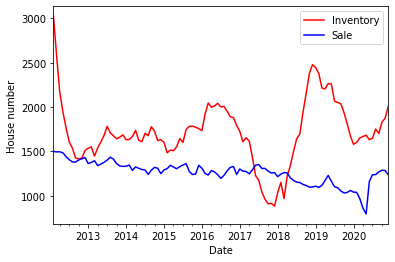

In [450]:
# line plot to show inventory and sale as a function of years
ax2 = plt.gca()
plt.ylabel('House number')
D_S.plot(kind='line',x='Date',y='Inventory',color='red',ax=ax2)
D_S.plot(kind='line',x='Date',y='Sale',color='blue',ax=ax2)
plt.show()

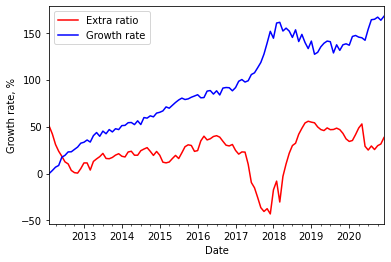

In [451]:
# line plot to show vacancy/sale vs house price as a function of years
ax3 = plt.gca()
plt.ylabel('Growth rate, %')

D_S.plot(kind='line',x='Date',y='Extra ratio',color='red',ax=ax3)
D_S.plot(kind='line',x='Date',y='Growth rate',color='blue',ax=ax3)

plt.show()

In [452]:
# linear regression and train-test set to get correlation variance sore between supply and house price growth
msk = np.random.rand(len(D_S)) < 0.8
train = D_S[msk]
test = D_S[~msk]


from sklearn import linear_model
regr = linear_model.LinearRegression()
x = np.asanyarray(train[['Extra ratio']])
y = np.asanyarray(train[['Growth rate']])
regr.fit (x, y)
# The coefficients
print ('Coefficients: ', regr.coef_)

y_hat= regr.predict(test[['Extra ratio']])
x = np.asanyarray(test[['Extra ratio']])
y = np.asanyarray(test[['Growth rate']])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x, y))

Coefficients:  [[0.26035175]]
Residual sum of squares: 2491.34
Variance score: -0.01


In [453]:
Santa_Clara=pd.read_excel("/Users/dwang/Downloads/Santa Clara county house summary.xlsx",skiprows=0,header=0, usecols="A:J")
Santa_Clara.head()

,Date,Condo price,Townhouse price,Single family price,Condo sale,Single family sale,Townhouse sale,Condo inventory,Single family inventory,Townhouse inventory
0,2012-02-01,248000,402500.0,529000.0,193,763,130,352,1734,220
1,2012-03-01,267000,451821.0,575000.0,272,1031,200,295,1608,200
2,2012-04-01,267000,435000.0,622500.0,246,1108,183,300,1526,178
3,2012-05-01,285000,457500.0,625000.0,262,1317,206,262,1563,180
4,2012-06-01,284250,515000.0,680000.0,246,1195,193,247,1563,148


In [454]:
# Calculate house price growth and Vacancy/sale ratio for 3 types of houses
Santa_Clara['Condo_P']=(Santa_Clara['Condo price']-Santa_Clara['Condo price'][0])/Santa_Clara['Condo price'][0]*100
Santa_Clara['Townhouse_P']=(Santa_Clara['Townhouse price']-Santa_Clara['Townhouse price'][0])/Santa_Clara['Townhouse price'][0]*100
Santa_Clara['SFH_P']=(Santa_Clara['Single family price']-Santa_Clara['Single family price'][0])/Santa_Clara['Single family price'][0]*100
Santa_Clara['Condo_IS']=(Santa_Clara['Condo inventory']-Santa_Clara['Condo sale'])/Santa_Clara['Condo sale']*100
Santa_Clara['Townhouse_IS']=(Santa_Clara['Townhouse inventory']-Santa_Clara['Townhouse sale'])/Santa_Clara['Townhouse sale']*100
Santa_Clara['SFH_IS']=(Santa_Clara['Single family inventory']-Santa_Clara['Single family sale'])/Santa_Clara['Single family sale']*100

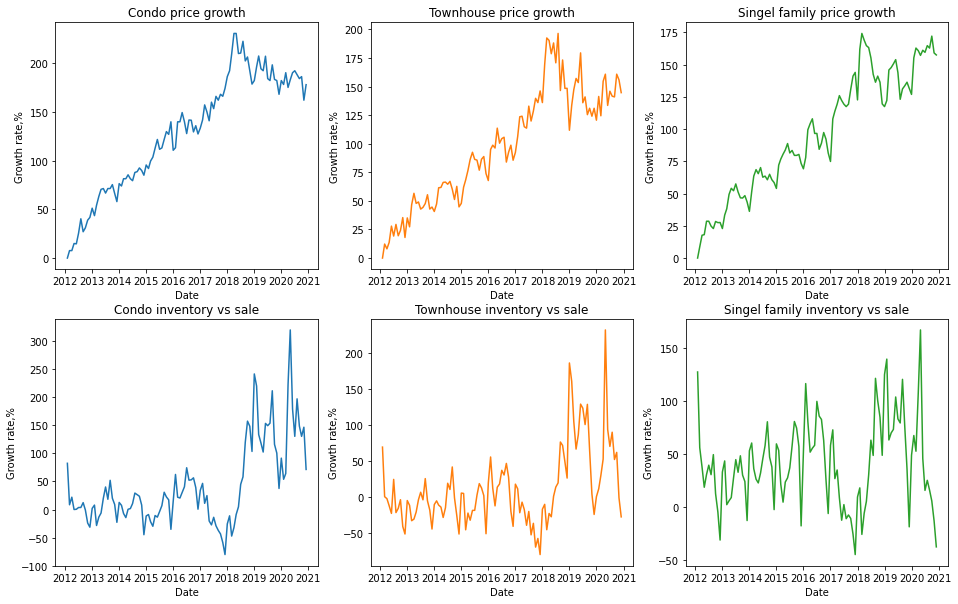

In [455]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(16,10,forward=True)
axs[0,0].plot(Santa_Clara['Date'], Santa_Clara['Condo_P'])
axs[0,0].set_title ('Condo price growth')
axs[0,1].plot(Santa_Clara['Date'], Santa_Clara['Townhouse_P'], 'tab:orange')
axs[0,1].set_title ('Townhouse price growth')
axs[0,2].plot(Santa_Clara['Date'], Santa_Clara['SFH_P'], 'tab:green')
axs[0,2].set_title ('Singel family price growth')
axs[1,0].plot(Santa_Clara['Date'], Santa_Clara['Condo_IS'])
axs[1,0].set_title ('Condo inventory vs sale')
axs[1,1].plot(Santa_Clara['Date'], Santa_Clara['Townhouse_IS'], 'tab:orange')
axs[1,1].set_title ('Townhouse inventory vs sale')
axs[1,2].plot(Santa_Clara['Date'], Santa_Clara['SFH_IS'], 'tab:green')
axs[1,2].set_title ('Singel family inventory vs sale')
for ax in axs.flat:
    ax.set(xlabel='Date', ylabel='Growth rate,%')

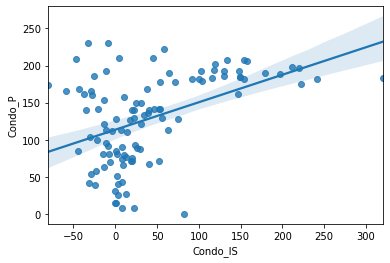

In [456]:
sns.regplot(x='Condo_IS', y='Condo_P',data=Santa_Clara)

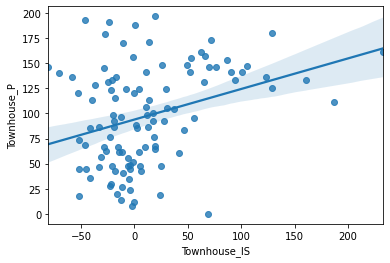

In [457]:
sns.regplot(x='Townhouse_IS', y='Townhouse_P',data=Santa_Clara)

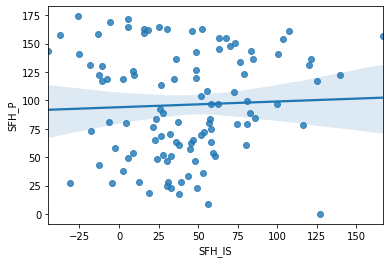

In [458]:
sns.regplot(x='SFH_IS', y='SFH_P',data=Santa_Clara)

In [459]:
Neighborhood=pd.read_excel("/Users/dwang/Downloads/final-small-area-neighborhood-data-for-web.xls",skiprows=0,header=0, usecols=['City','Neighborhood','White','Unemployed (ages ≥ 16 years)','Median household income','College graduate or higher',' Births per 1,000 people','Overcrowded households','Number of motor vehicle collisions, 1 year ','Life expectancy','Average distance (miles) to nearest full-service grocery store ','Foreign-born', 'Average household size','Households with gross rent 30% or more of household income','Average number of violent crimes within 1 mile ','Families below 185% FPL'])
median_price=pd.read_excel("/Users/dwang/Downloads/med_sale_price-5.xlsx",skiprows=1,header=0, usecols=[0,107])
median_price.head()

,Region,2020-12-01 00:00:00
0,"Campbell, CA",1500000
1,"Cupertino, CA",2359000
2,"Gilroy, CA",922750
3,"Los Altos Hills, CA",4205000
4,"Los Gatos, CA",1900000


In [460]:
Neighborhood1=Neighborhood.groupby(['City']).mean().sort_values(by=['City'])
Neighborhood1=Neighborhood1.drop(index='Unincorporated')
median_price.rename(columns = {list(median_price)[1]: 'Median price'}, inplace = True)
Neighborhood1['Median price']=median_price['Median price'].values
Neighborhood1

,White,Foreign-born,Average household size,Median household income,Unemployed (ages ≥ 16 years),Families below 185% FPL,College graduate or higher,"Number of motor vehicle collisions, 1 year",Average distance (miles) to nearest full-service grocery store,Households with gross rent 30% or more of household income,Overcrowded households,Average number of violent crimes within 1 mile,"Births per 1,000 people",Median price
City,,,,,,,,,,,,,,
Campbell,0.570000,0.226667,2.456667,79844.666667,0.050000,0.133333,0.453333,35.000000,0.752222,0.473333,0.040000,14.872222,12.389100,1500000
Cupertino,0.275000,0.505000,2.937083,127488.250000,0.045000,0.057500,0.752500,45.000000,1.085208,0.297500,0.057500,4.127917,7.545950,2359000
Gilroy,0.292500,0.257500,3.506250,71632.250000,0.085000,0.260000,0.212500,24.000000,0.943750,0.565000,0.095000,15.741250,16.934625,922750
Los Altos/Los Altos Hills,0.682500,0.252500,2.747083,181381.000000,0.030000,0.037500,0.795000,26.250000,1.266042,0.247500,0.007500,1.749375,6.074100,4205000
Milpitas,0.146000,0.482000,3.356400,93984.800000,0.046000,0.132000,0.392000,48.200000,0.971867,0.482000,0.070000,2.825200,13.160460,1900000
Monte Sereno/Los Gatos,0.775000,0.165000,2.510000,137233.000000,0.035000,0.045000,0.665000,63.500000,1.152000,0.420000,0.005000,3.207750,7.270850,1263750
Morgan Hill,0.510000,0.186667,3.073889,97601.000000,0.060000,0.160000,0.386667,23.666667,1.570278,0.513333,0.063333,2.908611,12.032167,1072500
Mountain View,0.468333,0.373333,2.320972,94768.666667,0.053333,0.155000,0.598333,42.500000,0.729861,0.358333,0.056667,14.288472,15.486067,1409500
Palo Alto,0.581667,0.303333,2.366806,112829.666667,0.030000,0.103333,0.820000,65.833333,1.227778,0.413333,0.025000,8.138889,8.529967,2700000


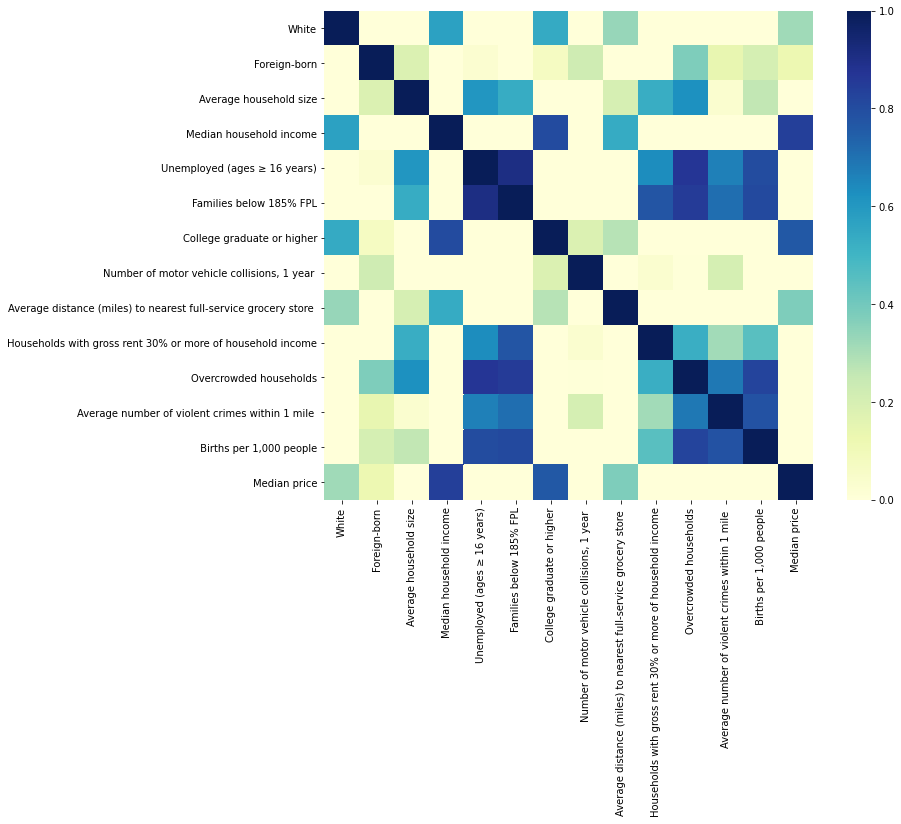

In [461]:
#Identify the relationship across all the variables
import seaborn as sns
corrmat = Neighborhood1.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat,vmin = 0,vmax=1,square=True,cmap="YlGnBu",ax=ax)
plt.show() #not mix with other similar graph

In [462]:
school_raw=pd.read_csv("/Users/dwang/Downloads/California_Schools_2019-20_SCR.csv",skiprows=0,header=0, usecols=['CountyName','SchoolName','SchoolType','SchoolRanking','City','Latitude','Longitude'])
school_raw=school_raw[school_raw["SchoolRanking"]>7]
school_raw.head()

,CountyName,SchoolName,SchoolType,SchoolRanking,City,Latitude,Longitude
8326,Santa Clara,Steindorf STEAM K-8 Magnet,Elementary,8.0,San Jose,37.26660,-121.91988
8332,Santa Clara,Forest Hill Elementary,Elementary,9.0,San Jose,37.27606,-121.98249
8334,Santa Clara,Marshall Lane Elementary,Elementary,8.0,Saratoga,37.26259,-121.99690
8378,Santa Clara,Village,Elementary,8.0,Campbell,37.26436,-121.96466
8380,Santa Clara,Blue Hills Elementary,Elementary,9.0,Saratoga,37.28921,-122.02523


In [463]:
school=school_raw[school_raw['CountyName']=='Santa Clara']
school=school.drop(columns='CountyName').reset_index(drop=True)

In [472]:
# Foursquare API
CLIENT_ID = 'W110MNXVIHWQAFLQICCDPW1FAVSTFPU3CTQRQ4WEDWR2FD32' # your Foursquare ID
CLIENT_SECRET = '1SDKBGWRLEALIKT03Y34CGE1B45J1LW35BSD5H5H4OCKZ04S' # your Foursquare Secret
ACCESS_TOKEN = '3LDTG4JSPNZSL5WJ3UWDKFGUJ3054WGBRZH4SEWE2FYTQMTX' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: W110MNXVIHWQAFLQICCDPW1FAVSTFPU3CTQRQ4WEDWR2FD32
CLIENT_SECRET:1SDKBGWRLEALIKT03Y34CGE1B45J1LW35BSD5H5H4OCKZ04S


In [465]:
towns=Neighborhood1.index.tolist()
towns[3:6]=['Los Altos', 'Milpitas','Los Gatos']
towns

['Campbell',
 'Cupertino',
 'Gilroy',
 'Los Altos',
 'Milpitas',
 'Los Gatos',
 'Morgan Hill',
 'Mountain View',
 'Palo Alto',
 'San Jose',
 'Santa Clara',
 'Saratoga',
 'Sunnyvale']

In [466]:
county_coor=pd.read_excel("/Users/dwang/Downloads/Santa Clara city coordination.xlsx",skiprows=0,header=0, usecols='A:C')
county_coor.head()

,City,Latitude,Longitude
0,Campbell,37.287165,-121.949957
1,Cupertino,37.322998,-122.032182
2,Gilroy,37.005782,-121.568275
3,Los Altos,37.385218,-122.114130
4,Milpitas,37.432334,-121.899574


In [467]:
company=pd.read_csv("/Users/dwang/Downloads/companies.csv",skiprows=0,header=0, usecols=['Company Name','City','Latitude','Longitude'])
company_santa=company.loc[company['City'].isin (towns)]
company_santa

,Company Name,City,Latitude,Longitude
5,23andMe,Mountain View,37.395208,-122.079159
14,Addepar,Mountain View,37.392670,-122.080849
42,Ambient.ai,Palo Alto,37.447222,-122.158617
43,AMD,Santa Clara,37.382925,-121.970384
54,Apple,Cupertino,37.331820,-122.031180
...,...,...,...,...
1076,Forcepoint,Los Gatos,37.249966,-121.967384
1078,AgilOne,Sunnyvale,37.395589,-122.031758
1079,MetricStream,Palo Alto,37.448524,-122.118314
1081,Tata Consultancy Services,Santa Clara,37.406306,-121.976493


In [468]:
#create map of South bay area using latitude and longitude values
map_bay = folium.Map(location=[county_coor['Latitude'][0], county_coor['Longitude'][0]], zoom_start=10)

# add city markers to map
for lat, lng, City in zip(county_coor['Latitude'], county_coor['Longitude'], county_coor['City']):
    label = '{}'.format(City)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bay)  
    
# add public school markers to map    
for lat, lng, school in zip(school['Latitude'], school['Longitude'],school['SchoolName']):
    label = '{}'.format(school)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        fill=True,
        color='orange',
        fill_color='orange',
        fill_opacity=0.6
        ).add_to(map_bay)

# add company markers to map
for lat, lng, company in zip(company_santa['Latitude'], company_santa['Longitude'],company_santa['Company Name']):
    label = '{}'.format(company)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
        ).add_to(map_bay)

In [469]:
# Search Asian food from 12 cities from Santa Clara county
for i in range(12):
    lat=county_coor['Latitude'][i]
    lng=county_coor['Longitude'][i]
    Company=company_santa[company_santa['City']==county_coor['City'][i]]
    search_query = 'Asian'
    radius = 5000
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat,lng, ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
    results = requests.get(url).json()
    venues = results['response']['venues']
    # tranform venues into a dataframe
    dataframe = pd.concat([dataframe,json_normalize(venues)],ignore_index=True)
    # keep only columns that include venue name, and anything that is associated with location
    filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
    dataframe_filtered = dataframe.loc[:, filtered_columns]
dataframe_filtered    

/Users/dwang/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  if sys.path[0] == '':


,name,categories,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,id
0,Asian Box Street Food,"[{'id': '4bf58dd8d48988d142941735', 'name': 'A...",1875 S Bascom Ave,Campbell Ave,37.287960,-121.933282,"[{'label': 'display', 'lat': 37.2879599, 'lng'...",1479,95008,US,Campbell,CA,United States,"[1875 S Bascom Ave (Campbell Ave), Campbell, C...",59ebd69d4382ab1d581a83e3
1,Asian Sisters Pad,"[{'id': '4bf58dd8d48988d1f1931735', 'name': 'G...",Impala Dr,at Winchester,37.296187,-121.952483,"[{'label': 'display', 'lat': 37.29618717, 'lng...",1028,95117,US,San Jose,CA,United States,"[Impala Dr (at Winchester), San Jose, CA 95117]",4dfc160fd4c001cca36b7d89
2,Asian Americans for Community Involvement,"[{'id': '4bf58dd8d48988d130941735', 'name': 'B...",2400 Moorpark Ave Ste 216,NaN,37.315718,-121.936859,"[{'label': 'display', 'lat': 37.31571768951272...",3383,95128,US,San Jose,CA,United States,"[2400 Moorpark Ave Ste 216, San Jose, CA 95128]",4c7bd65488449eb09989ab79
3,Asian Massage Mei Ni Spa,"[{'id': '52f2ab2ebcbc57f1066b8b3c', 'name': 'M...",1080 Saratoga Ave # 4,NaN,37.305847,-121.977707,"[{'label': 'display', 'lat': 37.305847, 'lng':...",3219,95129,US,San Jose,CA,United States,"[1080 Saratoga Ave # 4, San Jose, CA 95129]",5ad82b0b8c35dc49024c39f8
4,Asian Express,"[{'id': '4bf58dd8d48988d142941735', 'name': 'A...",1699 W San Carlos St,NaN,37.323813,-121.921799,"[{'label': 'display', 'lat': 37.32381274229858...",4781,95128,US,San Jose,CA,United States,"[1699 W San Carlos St, San Jose, CA 95128]",4e24ef5a483bbcc48dc0bb1c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522,Asian Man Records,"[{'id': '4deefb944765f83613cdba6e', 'name': 'H...",NaN,NaN,37.237634,-121.984198,"[{'label': 'display', 'lat': 37.23763373284994...",4611,NaN,US,Monte Sereno,CA,United States,"[Monte Sereno, CA]",53767571498e4456c1699900
523,Asian Massage Mei Ni Spa,"[{'id': '52f2ab2ebcbc57f1066b8b3c', 'name': 'M...",1080 Saratoga Ave # 4,NaN,37.305847,-121.977707,"[{'label': 'display', 'lat': 37.305847, 'lng':...",5595,95129,US,San Jose,CA,United States,"[1080 Saratoga Ave # 4, San Jose, CA 95129]",5ad82b0b8c35dc49024c39f8
524,Asian Sisters Pad,"[{'id': '4bf58dd8d48988d1f1931735', 'name': 'G...",Impala Dr,at Winchester,37.296187,-121.952483,"[{'label': 'display', 'lat': 37.29618717, 'lng...",6704,95117,US,San Jose,CA,United States,"[Impala Dr (at Winchester), San Jose, CA 95117]",4dfc160fd4c001cca36b7d89
525,South Asian Heart Center Los Gatos,"[{'id': '4bf58dd8d48988d104941735', 'name': 'M...",777 Knowles Drive Suite 17A,NaN,37.262175,-121.968551,"[{'label': 'display', 'lat': 37.2621746, 'lng'...",4557,95032,US,Los Gatos,CA,United States,"[777 Knowles Drive Suite 17A, Los Gatos, CA 95...",5bb630a0c47cf9002c7d0210


In [470]:
  # function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']

    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

# add the Asian places as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        color='green',
        popup=label,
        fill = True,
        fill_color='green',
        fill_opacity=0.5
    ).add_to(map_bay)

# display map
map_bay